In [4]:
%pip install pillow
%pip install numpy
%pip install torch
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
from IPython.display import display

# First step - Single image

In [6]:
from PIL import Image,ImageDraw;

# The core structure
img = Image.new("RGB",(128,128),color= "white")

In [7]:
# Object that can be printed out
draw = ImageDraw.Draw(img)


draw.circle((64,64),radius=30,fill="black")

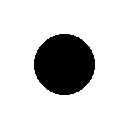

In [8]:
display(img)

# Second step - Make a bunch of random image

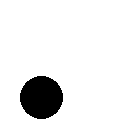

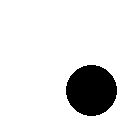

[None, None]

In [9]:
import random

l = []
for i in range(5000):
    img = Image.new("RGB",(128,128),"white")
    draw = ImageDraw.Draw(img)
    # Stay in side
    radius = random.randint(10,40)
    # For now we ensure the shape is inside the canva
    center = (random.randint(radius,128-radius),random.randint(radius,128-radius))
    draw.circle(xy=center,radius=radius,fill="black")
    l.append(img)
    img.save(f"data/train/circles/{i}.png")

[display(img) for img in l[50:52]]


In [10]:
l = []
for i in range(5000):
    img = Image.new("RGB",(128,128),"white")
    draw = ImageDraw.Draw(img)
    points = [
    (random.randint(10, 118), random.randint(10, 118)),
    (random.randint(10, 118), random.randint(10, 118)),
    (random.randint(10, 118), random.randint(10, 118)),
]
    draw.polygon(points,fill="black")
    l.append(img)
    img.save(f"data/train/triangles/{i}.png")

# Third make the model


# 

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
    

In [12]:
# A nice way to get the accelerato (whonever is training)
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

class ShapeCNN(nn.Module):
    # Define the layers of the neural net
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1)

        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)

        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride = 1,padding=1)


        # Diminish our image size by 2, note that does make it so it need to be divisible by 2 our input
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )

        #   Convert our bias and weight that we got from the neurons into a 256 a number i got from my ass.
        # So we dont have overfitting, this applies an afiine linear transformation which is in summary
        # A fancy way transformation of our previous vector into another vector, which follows a series of guidelines
        self.fc1 = nn.Linear(in_features=(64*16*16),out_features=256)
        self.fc2 = nn.Linear(256,2)



    # How tensors are treated as we move along the net neurons
    def forward(self,x):
        # Here we are in summary ignoring negative values and making positive values variant
        # A good metaphor is thinking that we are only getting the good tastes and not the bad ones
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)


        # This immediatelly creates the layer and inputs the x given by our neurons layers
        x = nn.Flatten()(x)


        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x 

    

# A nice way to see my model layers
model = ShapeCNN().to(device)
model

Using cuda device


ShapeCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

# Step 4 - Get my training data into the model

In [13]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [14]:

transform = transforms.ToTensor()
train_dataset = datasets.ImageFolder("data/train",transform=transform)
train_dataset

Dataset ImageFolder
    Number of datapoints: 10000
    Root location: data/train
    StandardTransform
Transform: ToTensor()

In [15]:
train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True)

In [16]:
train_features, train_labels = next(iter(train_loader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# Notice how we have inherited labels according to our previous folder division
print(train_labels.tolist()[:5])


Feature batch shape: torch.Size([64, 3, 128, 128])
Labels batch shape: torch.Size([64])
[1, 1, 1, 0, 0]


In [ ]:


def train_loop(model, train_loader,loss_fn,optimizer):
    # You need to tell the model he is in training mode
    model.train()
    for images,labels in train_loader:
        # Mode the data into the device
        images = images.to(device)
        labels = labels.to(device)

        # Attempt at predict - Learning part
        pred = model(images)
        loss = loss_fn(pred,labels)
        # Backpropagate - THE CHAIN RULE
        loss.backward()
        # Applies the gradients found by backpropagation
        optimizer.step()
        # Reset to not resum
        optimizer.zero_grad()




In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
train_loop(model=model,train_loader=train_loader,loss_fn = loss_fn,optimizer = optimizer)